## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [2]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [6]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
103
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|              res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|-0.9714474436583921|-20.310600885779007|-11.156771769950081|    135.9|BSBSSSSB| 32.6525| -84.1858|       SNWD|0.9983815327352802|0.2909069455126284|0.07743421845604893|0.9329420805591848|

In [7]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00091425| 32.6525| -84.1858|    135.9|-0.9714474436583921|
|USC00098661| 32.9028| -84.3367|    230.1|-0.9714474436583921|
|USC00092198|    33.1| -84.4333|    253.0|-0.9097054838385255|
|USC00093506| 33.0161| -83.9417|    195.1|-0.9097054838385255|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [8]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
29,US1GATY0002,32.4583,-84.2237,125.3,1,-0.948207
24,USC00010430,32.6000,-85.5000,198.7,5,9.094080


In [9]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
print _min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

-1.92551160469 517.909570739


u'#800000'

## Map

In [10]:
min_lat,max_lat,min_long,max_long = box = (31.7672, 33.2833, -85.5, -83.6)


In [11]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
_max_lat = -10000.0
_min_lat = 10000.0
_max_long = -10000.0
_min_long = 10000.0
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    if _lat > _max_lat:
        _max_lat = _lat
    elif _lat < _min_lat:
        _min_lat = _lat
    if _long > _max_long:
        _max_long = _long
    elif _long < _min_long:
        _min_long = _long
    _count=row['count(station)']
    _coef=row[_avg]
    print get_color(_coef)
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
print circles
print _max_lat, _max_long, _min_lat, _min_long
m    

#000080
#000096
#000080
#00009b
#000080
#000092
#000080
#00009b
#000096
#000080
#000084
#000084
#000092
#000084
#000084
#00009f
#800000
#000089
#000089
#000096
#000080
#0000cd
#000096
#00008d
#00009f
#000084
#0000d6
#000080
#00008d
#000084
#000089
#000089
#000080
#000092
#000089
#00008d
#000080
#000089
[<ipyleaflet.leaflet.Circle object at 0x112c18490>, <ipyleaflet.leaflet.Circle object at 0x10945c850>, <ipyleaflet.leaflet.Circle object at 0x10945c190>, <ipyleaflet.leaflet.Circle object at 0x10945c910>, <ipyleaflet.leaflet.Circle object at 0x10944fed0>, <ipyleaflet.leaflet.Circle object at 0x10945cad0>, <ipyleaflet.leaflet.Circle object at 0x10945c7d0>, <ipyleaflet.leaflet.Circle object at 0x10945cbd0>, <ipyleaflet.leaflet.Circle object at 0x10945cb10>, <ipyleaflet.leaflet.Circle object at 0x10945c3d0>, <ipyleaflet.leaflet.Circle object at 0x10945cb50>, <ipyleaflet.leaflet.Circle object at 0x10945c810>, <ipyleaflet.leaflet.Circle object at 0x10945c990>, <ipyleaflet.leaflet.Circle objec

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

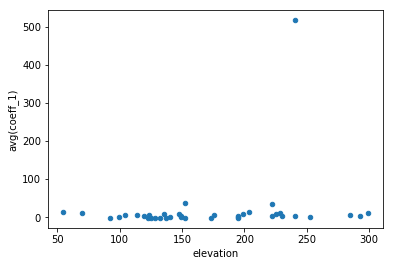

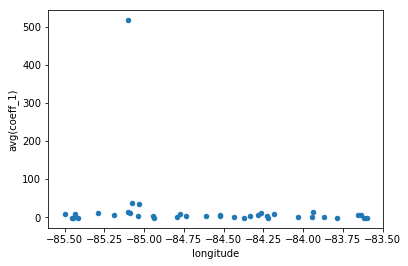

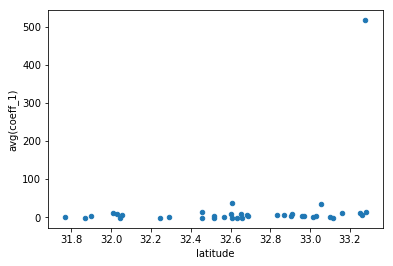

In [13]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');
pdf.plot.scatter(x='longitude',y='avg(coeff_1)');
pdf.plot.scatter(x='latitude',y='avg(coeff_1)');

In [29]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']